### Using the `poisbeta` package to investigate FSHD cells with and without DUX4 expression

* This notebook contains the following sections:
    1. Data processing
    2. DUX4+/- and Target +/- sorting
    3. Inference
    4. Parameter plot examples
    5. Wilcoxon tests
    6. Mean and variance analysis
    7. Mean absolute error calculation

In [1]:
import poisbeta
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
from poisbeta import fit_poisson_beta_moment

---
##### 1. Data processing

In [2]:
mRNA_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\mRNA_data_vdh.csv')

In [3]:
mRNA_df.rename(index = mRNA_df['Unnamed: 0'], inplace=True)
mRNA_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [4]:
mRNA_df.columns = [f"{cell_n}" for cell_n in range(len(mRNA_df.T))]

In [5]:
gene_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\gene_info_vdh.csv')
gene_df.rename(index = gene_df['ensembl_gene_id'], inplace=True)
gene_df.drop(["Unnamed: 0", "ensembl_gene_id"], axis=1, inplace=True)

In [6]:
cond_df = pd.read_csv(r'C:\Users\mvc28\OneDrive - University of Bath\data\kings_fshd\fshd_myocyte_rna_seq\condition_info_vdh.csv')
cond_df.rename(index = {0:"Disease", 1: "Patient"}, inplace=True)
cond_df.drop("Unnamed: 0", axis=1, inplace=True)
cond_df.columns = [f"{cell_n}" for cell_n in range(len(cond_df.T))]


In [7]:
# Combine dataframes
df = pd.concat([mRNA_df, cond_df])
df = pd.concat([df, gene_df], axis=1)

In [8]:
# Delete old from memory
del(mRNA_df)
del(gene_df)
del(cond_df)

In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,7040,7041,7042,7043,7044,7045,7046,entrezgene_id,hgnc_symbol,transcript_length
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100422919.0,MIR1302-11,712.0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,654835.0,FAM138A,1187.0
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,79501.0,OR4F5,918.0
ENSG00000238009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,2748.0
ENSG00000239945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,1319.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198727,31,2,38,12,85,48,1,58,31,2,...,4,20,0,6,21,13,32,4519.0,MT-CYB,1141.0
ENSG00000271254,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,101928050.0,NaN,4088.0
ENSG00000268674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100133301.0,FAM231B,510.0
Disease,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,FSHD,...,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,Ctrl,NaN,NaN,NaN


---
##### 2. DUX4+/- and Target +/- sorting

In [11]:
def create_fshd_dux4_plus_targets_input(df, genes):
    gene_index = df[df["hgnc_symbol"].isin(genes)].index.values
    patient_cols = [col for col in df.columns if df[col]["Disease"] != "Ctrl"]

    n_df = df[patient_cols].copy()
    n_df.columns = [f"Cell{cell_n + 1}" for cell_n in range(n_df.shape[1])]

    n_df = n_df.filter(axis=0, items=gene_index)
    n_df.drop(columns=n_df.columns[-3:], inplace=True)
    
    n_df.index = genes

    return n_df

def sort_by_dux4(df):
    '''
    Sorts dataframe into DUX4+ and DUX4- cells 
    '''

    # DUX4 containing cells
    dux4_cols = [col for col in df.columns if df[col]["DUX4"] != 0]
    dux4_df = df[dux4_cols].copy()
    dux4_df.sort_index(inplace=True)

    # Non-DUX4 containing cells
    neg_cols = [col for col in df.columns if df[col]["DUX4"] == 0]
    neg_df = df[neg_cols].copy()
    neg_df.sort_index(inplace=True)

    return dux4_df, neg_df

In [12]:
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]

fshd_df = create_fshd_dux4_plus_targets_input(df, genes)

In [13]:
dux4_df, neg_df = sort_by_dux4(fshd_df)

In [14]:
dux4_df

,Cell17,Cell479,Cell512,Cell541,Cell598,Cell812,Cell903,Cell1151,Cell1241,Cell1272,...,Cell1862,Cell2186,Cell2547,Cell2896,Cell3140,Cell3326,Cell3727,Cell3890,Cell4053,Cell4600
DUX4,1,2,5,2,1,1,2,2,2,1,...,2,1,3,1,1,1,1,1,1,1
PRAMEF1,0,2,0,0,0,0,0,0,44,0,...,0,0,0,0,10,0,0,0,0,383
PRAMEF12,0,7,0,0,0,0,0,1,10,0,...,0,0,1,0,2,0,0,2,0,96
PRAMEF2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,17
RFPL1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,28,0,0,0,0,111
RFPL2,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,106
RFPL4B,0,46,14,5,0,0,0,1,141,0,...,0,0,0,0,76,0,10,5,0,231
TRIM43,0,2,0,0,0,0,0,1,12,0,...,0,0,0,0,5,0,2,1,0,245
ZSCAN4,0,69,0,3,0,0,0,10,86,0,...,0,0,26,0,51,0,16,2,0,127


In [ ]:
def sort_by_dux4_and_target(df):
    '''
    Sorts cells into DUX4+/- and Target +/- groups
    '''

    # DUX4 containing cells
    dux4_cols = [col for col in df.columns if df[col]["DUX4"] != 0]
    dux4_df = df[dux4_cols].copy()
    dux4_row = dux4_df.loc['DUX4']

    # DUX4 and target containing cells
    targ_df = dux4_df.drop(index="DUX4")
    dux4_targ_cols = [col for col in targ_df if targ_df[col].max() != 0]
    dux4_targ_df = targ_df[dux4_targ_cols].copy()
    dux4_targ_df.loc['DUX4'] = dux4_row
    dux4_targ_df.sort_index(inplace=True)

    # DUX4 cells with no target
    dux4_no_targ_cols = [col for col in targ_df if targ_df[col].max() == 0]
    dux4_no_targ_df = targ_df[dux4_no_targ_cols].copy()
    dux4_no_targ_df.loc['DUX4'] = dux4_row
    dux4_no_targ_df.sort_index(inplace=True)

    # Non-DUX4 containing cells
    neg_cols = [col for col in df.columns if df[col]["DUX4"] == 0]
    neg_df = df[neg_cols].copy()

    # Non-DUX4 cells with targets
    neg_targ_cols = [col for col in neg_df if neg_df[col].max() != 0]
    neg_targ_df = neg_df[neg_targ_cols].copy()
    neg_targ_df.sort_index(inplace=True)

    # Non-DUX4 cells with no targets
    neg_no_targ_cols = [col for col in neg_df if neg_df[col].max() == 0]
    neg_no_targ_df = neg_df[neg_no_targ_cols].copy()
    neg_no_targ_df.sort_index(inplace=True)

    return neg_no_targ_df, dux4_no_targ_df, dux4_targ_df, neg_targ_df

In [ ]:
neg_no_targ_df, dux4_no_targ_df, dux4_targ_df, neg_targ_df = sort_by_dux4_and_target(fshd_df)

In [ ]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

bar_labels = ["DUX4-\nTarget-", "DUX4+\nTarget-", "DUX4+\nTarget+", "DUX4-\nTargets+",]

cmap = plt.colormaps['viridis']
c_list = cmap(np.linspace(0, 1, len(bar_labels)))

ax.bar(x=bar_labels, height=cell_n, color=c_list)
ax.tick_params(axis='x', labelrotation = 45)

ax.set_yscale('log')

ax.set_ylabel("FSHD cell count")

fig.tight_layout()
fig.savefig("fshd_cell_class_count.png", dpi=300)

In [ ]:
def cell_target_sum(df):
    return [df[col].sum() for col in df]

def cell_target_unique(df):
    return [len(df[col].to_numpy().nonzero()[0]) for col in df]

In [ ]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

data_list = [dux4_targ_df, neg_targ_df]
data_labels = ["DUX4+\nTarget+", "DUX4-\nTarget+"]

for index, data in enumerate(data_list):

    unique = cell_target_unique(data)
    sum = cell_target_sum(data)

    ax.scatter(unique, sum, color=c_list[index+2], label=data_labels[index])

ax.set_ylabel("DUX4 target mRNA molecules")
ax.set_xlabel("Unique DUX4 targets")

ax.set_yscale("log")

ax.legend()

fig.tight_layout()
fig.savefig(f"target_unique_sum_plot.png", dpi=300)

---
##### 3. Inference - see https://github.com/aksarkar/poisbeta/blob/master/src/poisbeta/mle.py for details

* Section contains examples of inference for full cell population, DUX4 subsets, and Target subsets.

In [16]:
def pb_inference(df, genes):
    theta_array = np.zeros((len(genes), 3))

    for index, gene in enumerate(genes):
        data = df.loc[gene].to_numpy('int32')

        if max(data) == 0:
            print(f"{genes[index]} gene has no transcripts.")
            
        else:
            try:
                theta = np.exp(poisbeta.fit_poisson_beta_mle(data))
                theta_array[index] = theta

            except:
                print(f"Inference failed for {genes[index]} gene")
                
                try:
                    init = np.log([1e-3, 1, 1])
                    theta = np.exp(poisbeta.fit_poisson_beta_mle(data, init=init))
                    theta_array[index] = theta
                
                except:
                    print(f"Inference with init failed for {genes[index]} gene")
    
    return theta_array

In [ ]:
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]
all_cell_df = create_fshd_dux4_plus_targets_input(df, genes)
all_cell_thetas = pb_inference(all_cell_df, genes)

In [ ]:
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]
pd.DataFrame(all_cell_thetas, index=genes, columns=["v0", "k0", "k1"]).sort_index().to_csv("all_fshd_cells_params.csv")

In [ ]:
genes = ["DUX4", "PRAMEF1", "PRAMEF12", "PRAMEF2", "RFPL1", "RFPL2", "RFPL4B", "TRIM43", "ZSCAN4"]

In [18]:
dux4_thetas = pb_inference(dux4_df, genes)

C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\special\_orthogonal.py:266: RuntimeWarning: overflow encountered in double_scalars
  mu0 = 2.0**(alpha+beta+1)*cephes.beta(alpha+1, beta+1)
C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\optimize\_optimize.py:811: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Inference failed for DUX4 gene
[-6.90775528  0.          0.        ]


In [19]:
dux4_thetas

array([[2.96447223e+00, 1.00321963e+00, 1.00119898e+00],
       [3.89474842e+02, 1.61216734e-02, 2.63598799e-01],
       [1.10382189e+02, 5.41987734e-02, 9.77584449e-01],
       [1.79741757e+01, 1.05980713e-02, 2.37039566e-01],
       [1.12158496e+02, 5.79610288e-03, 1.18929153e-01],
       [1.07503122e+02, 5.97643160e-03, 1.25331202e-01],
       [2.45263869e+02, 8.22655323e-02, 7.89324002e-01],
       [2.72945655e+02, 5.99357406e-02, 1.01453305e+00],
       [1.30856591e+02, 1.02920915e-01, 6.94920532e-01]])

In [20]:
neg_thetas = pb_inference(neg_df, genes)

DUX4 gene has no transcripts.


C:\Users\mvc28\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\poisbeta\mle.py:15: RuntimeWarning: invalid value encountered in matmul
  px = w.reshape(1, -1) @ st.poisson(mu=s * kr * p).pmf(x.reshape(1, -1))


In [21]:
neg_thetas

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32675857e+03, 8.86081169e-04, 3.20589826e+01],
       [6.92558034e+03, 2.09793366e-03, 1.01605927e+03],
       [2.64096285e+00, 1.17117984e-05, 1.12037003e-02],
       [2.61003314e+01, 5.67847815e-04, 1.02643571e+00],
       [9.65173391e+03, 1.13508241e-03, 3.77168445e+02],
       [8.94451748e+04, 2.24965925e-03, 1.01622344e+03],
       [1.28817577e+04, 2.23737932e-03, 6.28445164e+02],
       [3.27214090e+04, 2.91303086e-03, 1.01658355e+03]])

In [23]:
# To output csvs of data
cell_classes = [dux4_thetas, neg_thetas]
cell_class_names = ["dux4", "neg"]
[pd.DataFrame(theta, index=genes, columns=["v0", "k0", "k1"]).to_csv(f"all_fshd_cells_{cell_class_names[index]}_params.csv") for index, theta in enumerate(cell_classes)]

[None, None]

In [ ]:
genes = ["DUX4", "PRAMEF1", "PRAMEF12", "PRAMEF2", "RFPL1", "RFPL2", "RFPL4B", "TRIM43", "ZSCAN4"]
cell_classes = [neg_no_targ_df, dux4_no_targ_df, dux4_targ_df, neg_targ_df]
thetas = [pb_inference(cell_class, genes) for cell_class in cell_classes]

In [ ]:
cell_class_names = ["dux4_neg_targ_neg", "dux4_pos_targ_neg", "dux4_pos_targ_pos", "dux4_neg_targ_pos"]
[pd.DataFrame(theta, index=cell_classes[0].index.values, columns=["v0", "k0", "k1"]
                ).to_csv(f"fshd_cells_{cell_class_names[index]}_params.csv") 
                for index, theta in enumerate(thetas)]

---
##### 4. Parameter plot examples

In [92]:
def params_plot(mle_thetas, label=None):
    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, mle_thetas.shape[0]))

    for index, gene in enumerate(genes):
        k0_k1 = mle_thetas[index, 1] / mle_thetas[index, 2]
        ax.scatter(k0_k1, mle_thetas[index, 0], color=c_list[index])

    for index, gene in enumerate(genes):
        ax.scatter(0, 0, color=c_list[index], label=f"{gene}")

    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_ylabel("$v_0$")
    ax.set_xlabel("$k_0/k_1$")

    ax.set_ylim(1e0, 1e6)
    ax.set_xlim(1e-6, 2e0)

    fig.tight_layout()
    fig.savefig(f"mle_{label}_dux4_targets_fshd_patients.png", dpi=500)

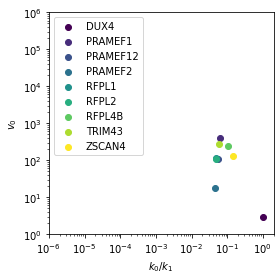

In [93]:
params_plot(dux4_thetas, "pos")

C:\Users\mvc28\AppData\Local\Temp\ipykernel_1444\1224780653.py:9: RuntimeWarning: invalid value encountered in double_scalars
  k0_k1 = mle_thetas[index, 1] / mle_thetas[index, 2]


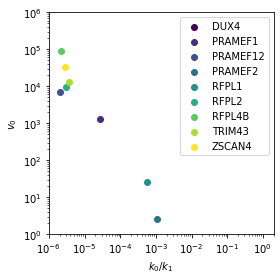

In [94]:
params_plot(neg_thetas, "neg")

---
##### 5. Wilcoxon tests

In [ ]:
st.wilcoxon(dux4_thetas, neg_thetas)

In [ ]:
# no dux4
st.wilcoxon(dux4_thetas[1:], neg_thetas[1:])

In [ ]:
# no dux4, single tailed
st.wilcoxon(dux4_thetas[1:], neg_thetas[1:], alternative="greater")

---
##### 6. Mean and variance analysis

In [ ]:
def theta_mean(theta):
    lambda1 = theta[0]
    alpha = theta[1]
    beta = theta[2]

    return lambda1 * alpha / (alpha + beta)

def theta_var(theta):
    lambda1 = theta[0]
    alpha = theta[1]
    beta = theta[2]

    return lambda1 * alpha / (alpha + beta) + (
                lambda1 ** 2 * alpha * beta / (alpha + beta) ** 2 / (alpha + beta + 1)
    )

def calc_theta_moments(thetas):
    moment_array = np.zeros((len(thetas), 2))

    for index, theta in enumerate(thetas):
            try:
                mean = theta_mean(theta)
                varience = theta_var(theta)
                moment_array[index] = mean, varience

            except:
                print(f"Moment calculation failed for {genes[index]} gene")

    return moment_array

In [ ]:
dux4_theta_moments = calc_theta_moments(dux4_thetas)
neg_theta_moments = calc_theta_moments(neg_thetas)

In [ ]:
scale = 4
fig, ax = plt.subplots(figsize=(scale, scale))

cmap = plt.colormaps['viridis']
c_list = cmap(np.linspace(0, 1, 4))

box = ax.boxplot([dux4_theta_moments[1:, 0], neg_theta_moments[1:, 0]],
            labels=["DUX4+ Target+", "DUX4- Target+"], patch_artist=True)

colors = [c_list[1], c_list[2]]
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')

ax.set_ylabel("Mean")

fig.tight_layout()

fig.savefig("mean_comparison_all_fshd.png", dpi=300)

---
##### 7. Mean absolute error calculation

In [ ]:
def create_patient_pb_dux4_plus_targets_input(df, patient, genes):
    gene_index = df[df["hgnc_symbol"].isin(genes)].index.values
    patient_cols = [col for col in df.columns if df[col]["Patient"] == patient]

    n_df = df[patient_cols].copy()
    n_df.columns = [f"Cell{cell_n + 1}" for cell_n in range(n_df.shape[1])]

    n_df = n_df.filter(axis=0, items=gene_index)
    data = [x for x in n_df[n_df.columns].to_numpy(dtype='int32')]
    
    return data

In [ ]:
def pb_inference(df, patients, genes, func, **keyargs):
    theta_array = np.zeros((len(patients), len(genes), 3))

    for index1, patient in enumerate(patients):
        patient_data = create_patient_pb_dux4_plus_targets_input(df, patient=patient, genes=genes)

        for index2, gene in enumerate(patient_data):
            if max(gene) == 0:
                print(f"Patient {patient}'s {genes[index2]} gene has no transcripts.")
                
            else:
                try:
                    theta = np.exp(func(gene, **keyargs))
                    theta_array[index1, index2] = theta

                except:
                    print(f"Inference failed for patient {patient}'s {genes[index2]} gene")
    
    return theta_array

In [ ]:
def target_genes_mae_plot(df, patients, genes, mle_thetas):

    scale = 4
    fig, ax = plt.subplots(figsize=(scale, scale))

    cmap = plt.colormaps['viridis']
    c_list = cmap(np.linspace(0, 1, len(patients)))

    cumsum_mae = 0

    for index1, patient in enumerate(patients):
        patient_data = create_patient_pb_dux4_plus_targets_input(df, patient=patient, genes=genes)

        for index2, gene in enumerate(genes):
            gene_data = patient_data[index2]

            if gene_data.max() != 0:
                theta = np.log(mle_thetas[index1, index2])

                grid = np.arange(gene_data.max() + 1)
                p = gene_data.shape[0] * np.array([poisbeta.mle.poisson_beta_pmf(theta=theta,
                                        x=i, s=1) for i in grid]).ravel()
                
                gene_hist = np.histogram(gene_data, np.append(grid, grid[-1] + 1))

                mae = np.mean(np.abs(gene_hist[0] - p))
                cumsum_mae = cumsum_mae + mae

                ax.scatter(genes[index2], mae, color=c_list[index1])

    for index1, patient in enumerate(patients):
            ax.scatter(0, 0, color=c_list[index1], label=f"Patient {patient}")

    ax.tick_params(axis='x', labelrotation = 45)
    ax.legend()
    ax.set_yscale("log")
    ax.set_ylim(2e-3, 8e0)
    ax.set_ylabel("Mean absolute error")
    
    print(cumsum_mae)

    fig.tight_layout()
    fig.savefig("mae_mle.png", dpi=300)

In [ ]:
patients = ["A", "B", "E", "F"]
genes = ["PRAMEF12", "PRAMEF1", "PRAMEF2", "TRIM43", "DUX4", "RFPL4B", "ZSCAN4", "RFPL1", "RFPL2"]

mle_thetas = pb_inference(df, patients, genes, lambda x: poisbeta.fit_poisson_beta_mle(x))

In [ ]:
target_genes_mae_plot(df, patients, genes, mle_thetas)

In [ ]:
def mae_csv(df, patients, genes, mle_thetas):

    mae_array = np.zeros((len(patients), len(genes)))

    for index1, patient in enumerate(patients):
        patient_data = create_patient_pb_dux4_plus_targets_input(df, patient=patient, genes=genes)

        for index2, gene in enumerate(genes):
            gene_data = patient_data[index2]

            if gene_data.max() != 0:
                theta = np.log(mle_thetas[index1, index2])

                grid = np.arange(gene_data.max() + 1)
                p = gene_data.shape[0] * np.array([poisbeta.mle.poisson_beta_pmf(theta=theta,
                                        x=i, s=1) for i in grid]).ravel()
                
                gene_hist = np.histogram(gene_data, np.append(grid, grid[-1] + 1))

                mae = np.mean(np.abs(gene_hist[0] - p))
                mae_array[index1, index2] = mae

    np.savetxt("mle_mae.csv", mae_array, delimiter=",")

In [ ]:
mae_csv(df, patients, genes, mle_thetas)